In [1]:
import torch
import torchaudio

import numpy as np
import pandas as pd

import os

from scipy.io import wavfile as wav
from functools import lru_cache

from tqdm import tqdm, trange

from src.audio_dataset import AudioDataset

/Users/rkd/Research/Monke/cmci/venv/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [2]:
class Files:
    data_loc = 'data/Calls for ML/'

    # create symlinks so that all the data can be seen from labelled_data
    lb_data_loc = 'data/Calls for ML/labelled_data/'

    state_dict = 'data/Calls for ML/simple_rnn_sd.pth'

    ml_test = 'ML_Test.wav'
    labels_file = 'Calls_ML.xlsx'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = AudioDataset()
X_full, y_full, z_full = dataset[...]

100%|██████████| 799/799 [00:00<00:00, 12551.26it/s]


In [4]:
idx = np.random.choice(len(y_full), len(y_full), replace=False)
train_idx, test_idx = idx[:int(0.9*len(idx))], idx[int(0.9*len(idx)):]

X_train = X_full[train_idx, ...]
y_train = y_full[train_idx, ...]

X_test = X_full[test_idx, ...]
y_test = y_full[test_idx, ...].cpu().numpy().reshape(-1)
z_test = z_full[test_idx, ...].reshape(-1)

conv = {'Blackpool_Combined_FINAL': 'blackpool', 'Shaldon_Combined': 'shaldon',
        'ML_Test': 'banham', 'ML_Test_2a': 'banham', 'ML_Test_2b': 'banham'}

for k, repl in conv.items():
    z_test[z_test == k] = repl

X_test_2 = dataset.featurizer(dataset.audio['ML_Test_3']).T[None, ...]
y_test_2 = dataset.label_ts['ML_Test_3'].cpu().numpy()

In [36]:
class Classifier(torch.nn.Module):
    def __init__(self, num_inp, num_lstm=3):
        super().__init__()
        self.num_lstm = num_lstm
        self.lstm = torch.nn.LSTM(num_inp, 16, num_lstm, batch_first=True)
        self.fc = torch.nn.Linear(16, 1)

    def forward(self, x):
        x = (x - x.mean(axis=-1)[..., None]) / (x.std(axis=-1)[..., None] + 1e-9)
        h0 = torch.zeros(self.num_lstm, x.size(0), 16).to(x.device).normal_()*0.01
        c0 = torch.zeros(self.num_lstm, x.size(0), 16).to(x.device).normal_()*0.01

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out).sigmoid()[..., 0]
        return out

In [37]:
classifier = Classifier(40).to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [8]:
print(X_train.shape, X_val.shape, X_test.shape)

torch.Size([1811, 552, 40]) torch.Size([202, 552, 40]) torch.Size([224, 552, 40])


In [38]:
losses = []
iterator = trange(2000, leave=False)
for i in iterator:
    optimizer.zero_grad()
    idx = np.random.choice(len(y_train), 500)
    y_prob = classifier(X_train[idx])
    loss = criterion(y_prob, y_train[idx])
    # loss = -torch.distributions.Bernoulli(probs=y_prob).log_prob(y_train[idx]).sum()

    losses.append(loss.item())
    iterator.set_description(f'Loss: {np.round(loss.item(), 4)}')
    loss.backward()
    optimizer.step()

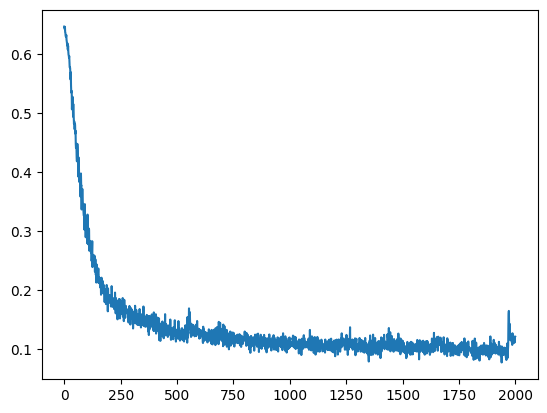

In [39]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

classifier.eval()
test_prob = classifier(X_test).detach().cpu().reshape(-1)
test_bin = test_prob.round().reshape(-1)

print('Accuracy:', accuracy_score(y_test, test_bin))
print('Precision:', precision_score(y_test, test_bin))
print('Recall:', recall_score(y_test, test_bin))
print('F1:', f1_score(y_test, test_bin))

Accuracy: 0.9543300336438924
Precision: 0.8794112863880306
Recall: 0.8897207025626259
F1: 0.8845359559981189


In [41]:
classifier.eval()
val_prob = classifier(X_val).detach().cpu().reshape(-1)
val_bin = val_prob.round().reshape(-1)

(0.0, 8000.0)

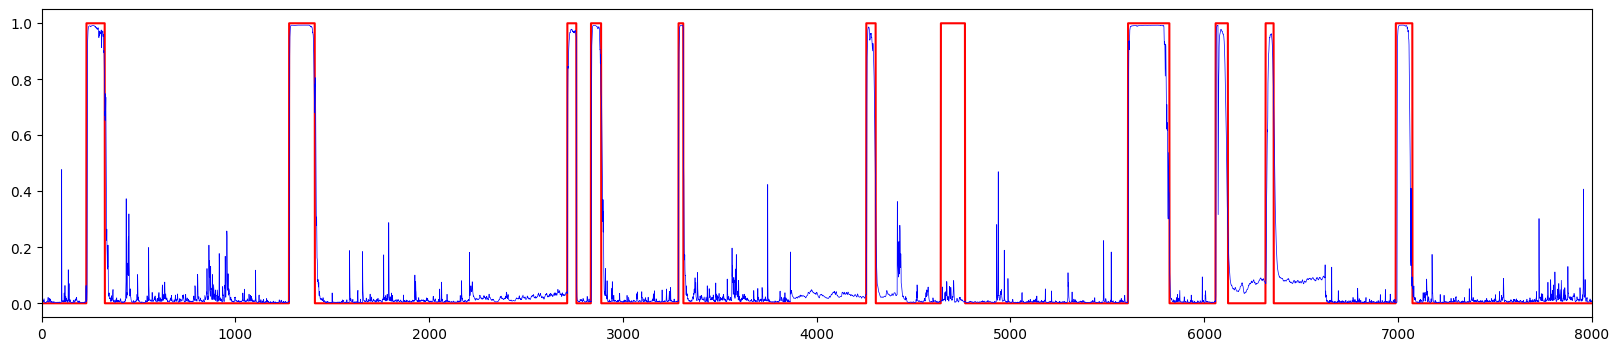

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
y_val_proper = y_val.cpu().numpy().reshape(-1)
plt.plot(y_val_proper, 'r')
plt.plot(val_prob, 'b', lw=0.5)

plt.xlim(0,8000)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy:', accuracy_score(y_val_proper, pred_bin))
print('Precision:', precision_score(y_val_proper, pred_bin))
print('Recall:', recall_score(y_val_proper, pred_bin))
print('F1:', f1_score(y_val_proper, pred_bin))

Accuracy: 0.9488628210647152
Precision: 0.9138800992046524
Recall: 0.8528332003192338
F1: 0.8823019444329769


(0.0, 8000.0)

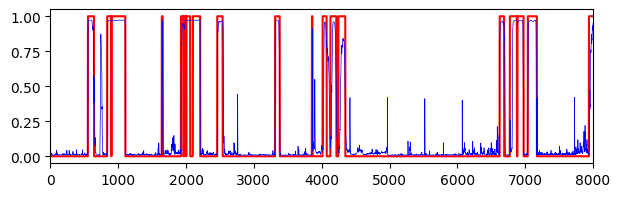

In [76]:
y_train_proper = y_train.cpu().numpy().reshape(-1)

plt.plot(y_train_proper, 'r')
plt.plot(classifier(X_train).detach().cpu().reshape(-1), 'b', lw=0.5)
plt.xlim(0, 8000)

In [55]:
X_train.shape

torch.Size([1811, 552, 40])

In [43]:
# Classify the X_val data. We want to select those that are above a threshold of 0.9, and get the corresponding X_val samples

val_pred = classifier(X_val).detach().cpu().numpy()

val_pred_bin = val_pred > 0.99

sums = []
for i in range(len(val_pred_bin)):
    sums.append(val_pred_bin[i].sum())
    
confident_indices = np.where(np.array(sums) > 0)[0]

X_val_confident = X_val[confident_indices]
y_val_confident = val_pred_bin[confident_indices]


In [44]:
y_val_confident.shape

(73, 552)

In [45]:
X_train_2nd = torch.cat([X_train, X_val_confident], axis=0)
y_train_2nd = torch.cat([y_train, torch.tensor(y_val_confident)], axis=0)

In [46]:
classifier2 = Classifier(40).to(device)
optimizer = torch.optim.Adam(classifier2.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

In [47]:
classifier2.train()
iterator = trange(2000, leave=False)
for i in iterator:
    optimizer.zero_grad()
    idx = np.random.choice(len(y_train_2nd), 500)
    y_prob = classifier2(X_train_2nd[idx])
    loss = criterion(y_prob, y_train_2nd[idx])

    losses.append(loss.item())
    iterator.set_description(f'Loss: {np.round(loss.item(), 4)}')
    # wandb.log(dict(l=loss.item(), tr=tr_cm, te=cm, te_mlt3=cm_2))
    loss.backward()
    optimizer.step()

Loss: 0.1664:  34%|███▍      | 675/2000 [08:19<16:33,  1.33it/s]

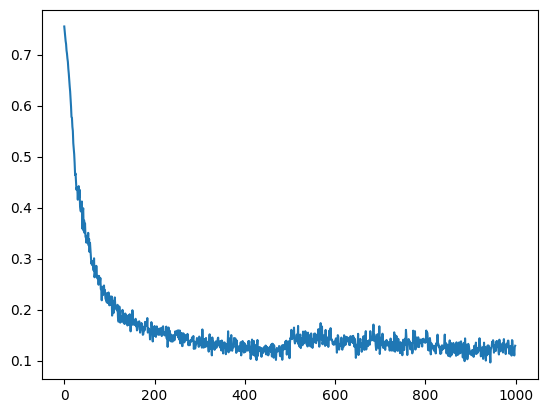

In [87]:
plt.plot(losses)


In [88]:
classifier.eval()
test_prob = classifier(X_test).detach().cpu().reshape(-1)
test_bin = test_prob.round().reshape(-1)

print('Accuracy:', accuracy_score(y_test, test_bin))
print('Precision:', precision_score(y_test, test_bin))
print('Recall:', recall_score(y_test, test_bin))
print('F1:', f1_score(y_test, test_bin))

Accuracy: 0.9510222567287785
Precision: 0.9240418626700215
Recall: 0.8644628663050523
F1: 0.8932600112803158


In [95]:
val_pred = classifier(X_val).detach().cpu().numpy()

val_pred_bin = val_pred > 0.9

sums = []
for i in range(len(val_pred_bin)):
    sums.append(val_pred_bin[i].sum())
    
confident_indices = np.where(np.array(sums) > 0)[0]

X_val_confident = X_val[confident_indices]
y_val_confident = val_pred_bin[confident_indices]

In [96]:
X_val_confident.shape

torch.Size([114, 552, 40])

In [93]:
val_pred.shape

(202, 552)

(0.0, 8000.0)

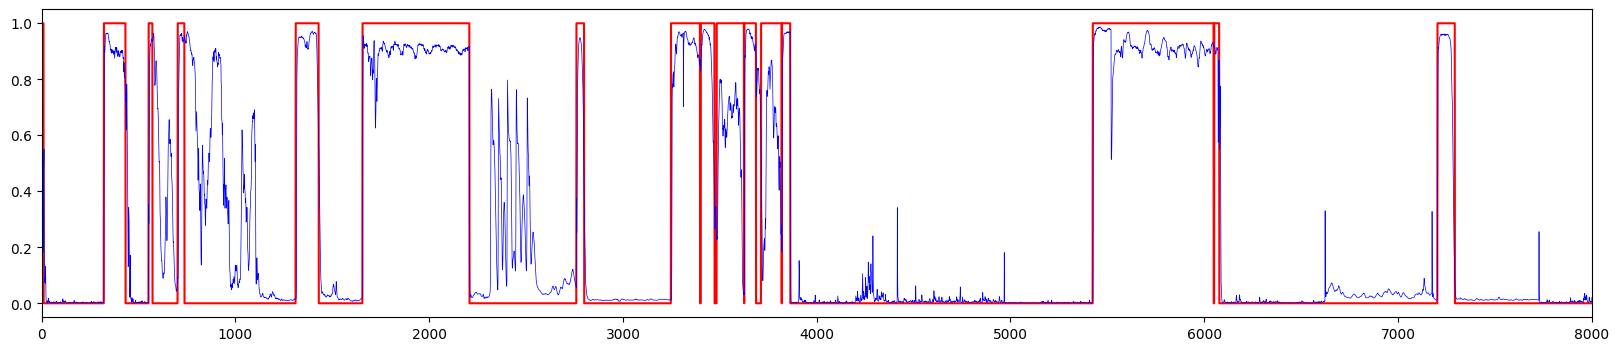

In [94]:

plt.figure(figsize=(20, 4))
plt.plot(y_val.flatten(), 'r')
plt.plot(val_pred.flatten(), 'b', lw=0.5)

plt.xlim(0,8000)

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy:', accuracy_score(y_test, pred_bin))
print('Precision:', precision_score(y_test, pred_bin))
print('Recall:', recall_score(y_test, pred_bin))
print('F1:', f1_score(y_test, pred_bin))

Accuracy: 0.9454661620082816
Precision: 0.9054410611138843
Recall: 0.8612514838053248
F1: 0.8827936243068953


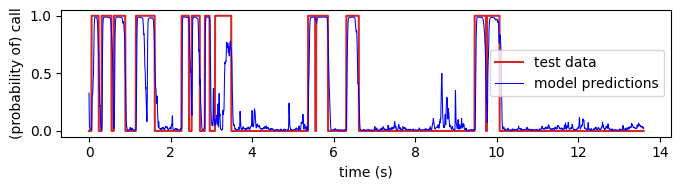

In [23]:
plt.rcParams["figure.figsize"] = (7, 2)
plt.plot(dataset.ts['Blackpool_Combined_FINAL'][:3000].cpu(), dataset.label_ts['Blackpool_Combined_FINAL'][:3000].cpu(), c='tab:red', label='test data')
plt.plot(dataset.ts['Blackpool_Combined_FINAL'][:3000].cpu(), classifier(dataset.features['Blackpool_Combined_FINAL'][None, :3000, :])[0].cpu().detach(), c='b', lw=0.75, label='model predictions')

plt.xlabel('time (s)')
plt.ylabel('(probability of) call')
plt.tight_layout()
plt.legend(loc='center right')

In [13]:
# Save model
torch.save(classifier.state_dict(), 'model.pt')


In [33]:
from sklearn.model_selection import train_test_split

X_train_sample, X_val, y_train_sample, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [36]:
X_test.shape

torch.Size([224, 552, 40])

In [29]:
dataset.features['Blackpool_Combined_FINAL'].shape[0]/199

2218.78391959799